## Identifying different persons using accelerometer data

The problem I am going to solve consist on identifying different persons (specifically 22 persons) by using acceleromenter data.

The dataset provided consists of accelerometer data of 22 unique, walking individuals, collected using a smartphone device. For every individual there are multiple recorded fragments of them walking, with variable durations. For some people there are more fragments than the others. In total there are 1857 walking-fragments, consisting of x, y and z acceleration values per unit of time, labeled with their relevant person ID. A sampling frequency of 50 Hz was considered when collecting each of the acceleration values that conform a given fragment.

I assumed the task is focused in solving a classification problem. Then I built a model that learns to identify persons using the acceleromenter data of the different walking-fragments. A time series (TS) is a collection of datapoints collected at constant time intervals. Then, the shape of each fragment (a set of x, y and z acceleration values) allows to get three time series, one for each of the axes of the acceleration values. 

The model I built consists of a Random Forest Classifier (RFC) with 59 trees. The main problem in our dataset is that data has imbalanced classes. Some of the most commonly used classification algorithms (e.g. SVM or KNN) do not work well with imbalanced data. They focus on minimizing the overall error rate, which makes difficult to learn the signature of those individuals with very small instances within the training data. As discussed below, sampling techniques such as undersampling and oversampling were used to tackle the problem of imbalanced classes. Moreover, I compared different performance metrics such as accuracy, precision, recall and F-score, between diverse configurations of RFC, SVM and KNN; obtaining a much better performance with the RFC approach. These metrics can provide a major understanding of the performance of the model over than just considering the traditional classification accuracy.

Below, I explained the main steps of the procedure to build and evalute the RFC model, as well as the prediction of the fragment tests required. 

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import pickle
import numpy as np

from Dataset import Dataset
from Visualization import Visualization
from Manipulate import Manipulate

from sklearn.ensemble import RandomForestClassifier
from imblearn.metrics import classification_report_imbalanced
from sklearn import metrics

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import ADASYN, SMOTE, RandomOverSampler

import json

In [3]:
#Load data into Dataset object
dt,vsl,mp = Dataset(),Visualization(),Manipulate()
dt.main()

The original distribution of classes in the original dataset is shown below. The three main classes are individuals with id 16, 17 and 19. The three least popular classes are the id 2, 4 and 18. The ratio of the most popular class (16) over the least popular class (18) is 23:1, which indicates that for every instance observed in 18 it is expected to see 23 instances of class 16.

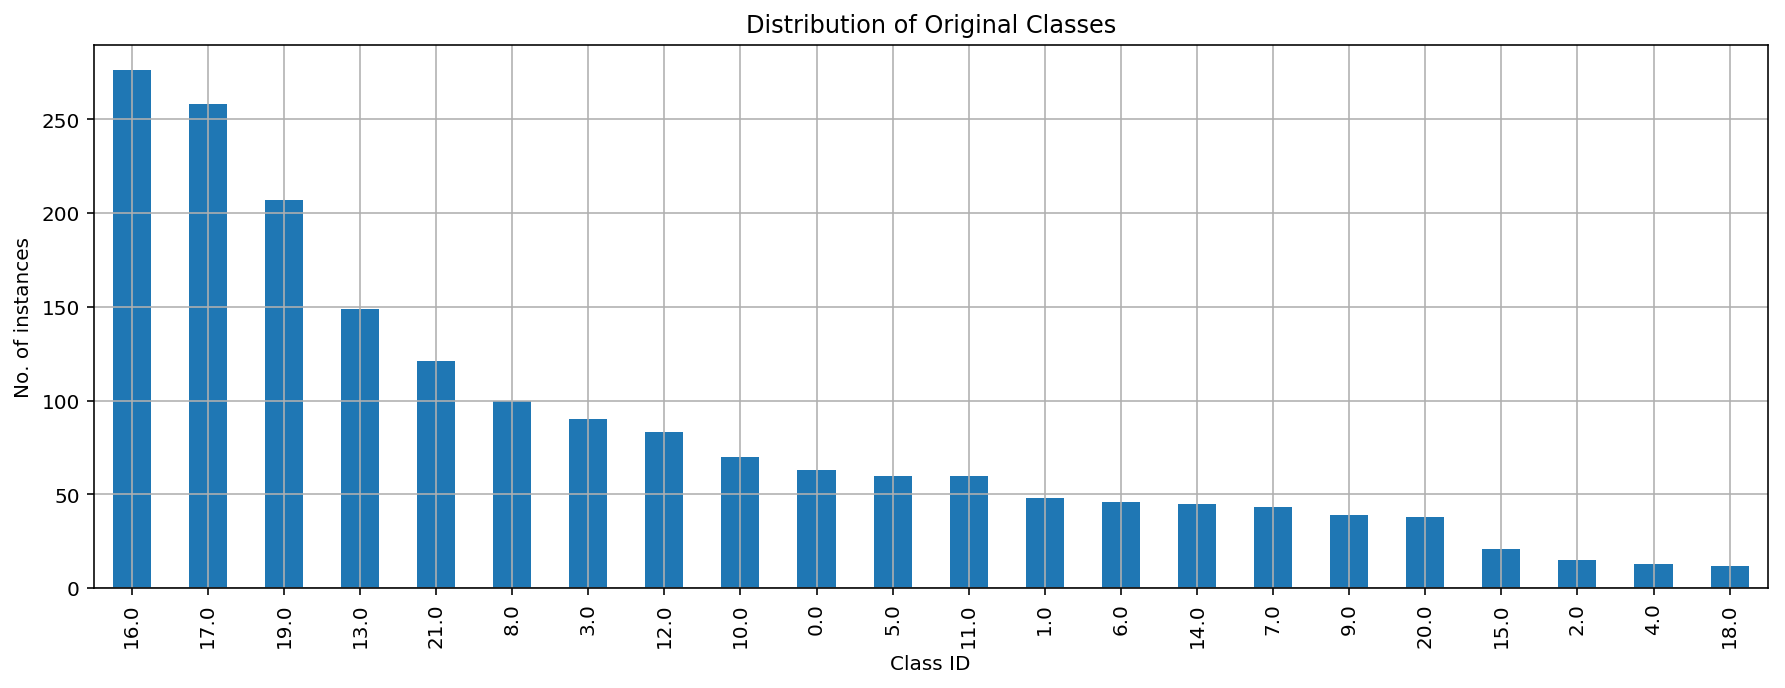

Original Classes shape Counter({16.0: 276, 17.0: 258, 19.0: 207, 13.0: 149, 21.0: 121, 8.0: 100, 3.0: 90, 12.0: 83, 10.0: 70, 0.0: 63, 5.0: 60, 11.0: 60, 1.0: 48, 6.0: 46, 14.0: 45, 7.0: 43, 9.0: 39, 20.0: 38, 15.0: 21, 2.0: 15, 4.0: 13, 18.0: 12})


In [4]:
dt.mapto_timeseries(sect="train")
dt.mapto_timeseries(sect="test")

vsl.counter(dt.raw_Ytrain,"Original Classes")

A sample of the data contained in a walking-fragment is observed below. In there, we can notice the corresponding acceleration value of X, Y and Z in a given time. For instance, in time t0 the acceleration value in X is -0.08, acceleration in Y is 9.95, and acceleration in Z is -0.23. We can observe a similar behavior in diverse intervals of time such as in time t1,t2 and so on.


In [5]:
dt.ts_train[0].head()

,x,y,z
0,-0.081722,9.9565,-0.23155
1,1.266700,8.6898,-0.65378
2,0.381370,9.7249,-0.88532
3,-0.653780,10.3790,-1.07600
4,-0.272410,8.8124,0.23155


In total 45 features were considered to help the model identifying each of the 22 individuals involved. These features focus mainly on describing a walking-fragment using statistical and time series related features, since this approach is based on analyzing time series data. In summary, for each of the three time series (X, Y and Z) the following 15 values were computed:
    
    - Statistical Features
        1. mean_D. The Mean 
        2. std_D. The Standard Deviation
        3. min_D. The Minimum value observed
        4. max_D. The Maximum value observed
        5. median_D. The Median
        6. var_D. The Variance
        7. autocorr_D. The Autocorrelation
        8. kur_D. The Kurtosis
        9. skew_D. The Skewness
    
    - Time series analysis related features
        10. c_D. The cross-correlation of the time series with the 2 remaining dimensions of the fragment
    
    - Other related features
        11. peaks_D. The Number of peaks in the time series
        12. zcros_D. The Number of zero crossings in the time series
        13. mcros_D. The Number of mean crossings in the time series
        14. inicial_D. The Initial value observed in the time series
        15. final_D. The Final value observed in the time series


In [6]:
all_data = mp.build_features(dt,sect='train')

The data provided is splitted into a random train and test subset for the purposes of training and evaluating the performance of the RFC model. 33% of the original given data conforms the test subset. RANDOM_STATE = 43 for the purpose of reproducibility.

In [17]:
# fix random state for reproducibility
np.random.seed(7)
RANDOM_STATE = 43

x_train, x_test, y_train, y_test = train_test_split(all_data, dt.raw_Ytrain, test_size=0.33, random_state=RANDOM_STATE)
print("Size of train data: ",len(x_train) , "\nSize of test data: ",len(x_test))

Size of train data:  1244 
Size of test data:  613


Below is observed the distribution of the train and test subsets. It is observed that in both subsets there are instances of each of the classes, therefore, it is sure that the model is trained and evaluated for each class.

In the training subset it is a ratio of around 27:1 between the samples of the most popular class over the least popular class; being class 16 the most popular label and class 18 the least popular. On the other side, the testing subset has a ratio of 88:1 between the samples of class 16 (the most popular) and class 4 (the least popular).

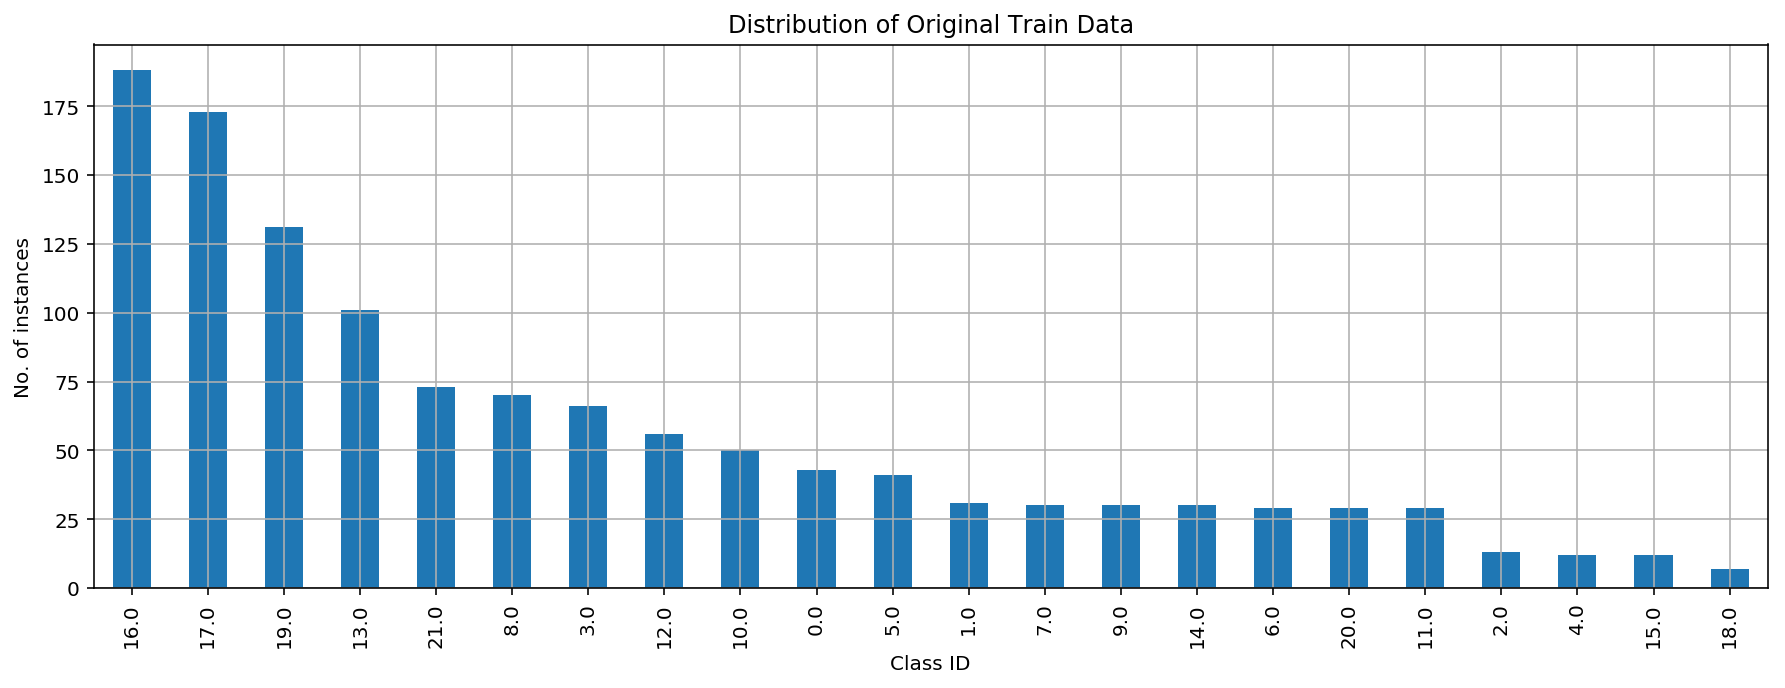

Original Train Data shape Counter({16.0: 188, 17.0: 173, 19.0: 131, 13.0: 101, 21.0: 73, 8.0: 70, 3.0: 66, 12.0: 56, 10.0: 50, 0.0: 43, 5.0: 41, 1.0: 31, 7.0: 30, 9.0: 30, 14.0: 30, 6.0: 29, 11.0: 29, 20.0: 29, 2.0: 13, 4.0: 12, 15.0: 12, 18.0: 7})


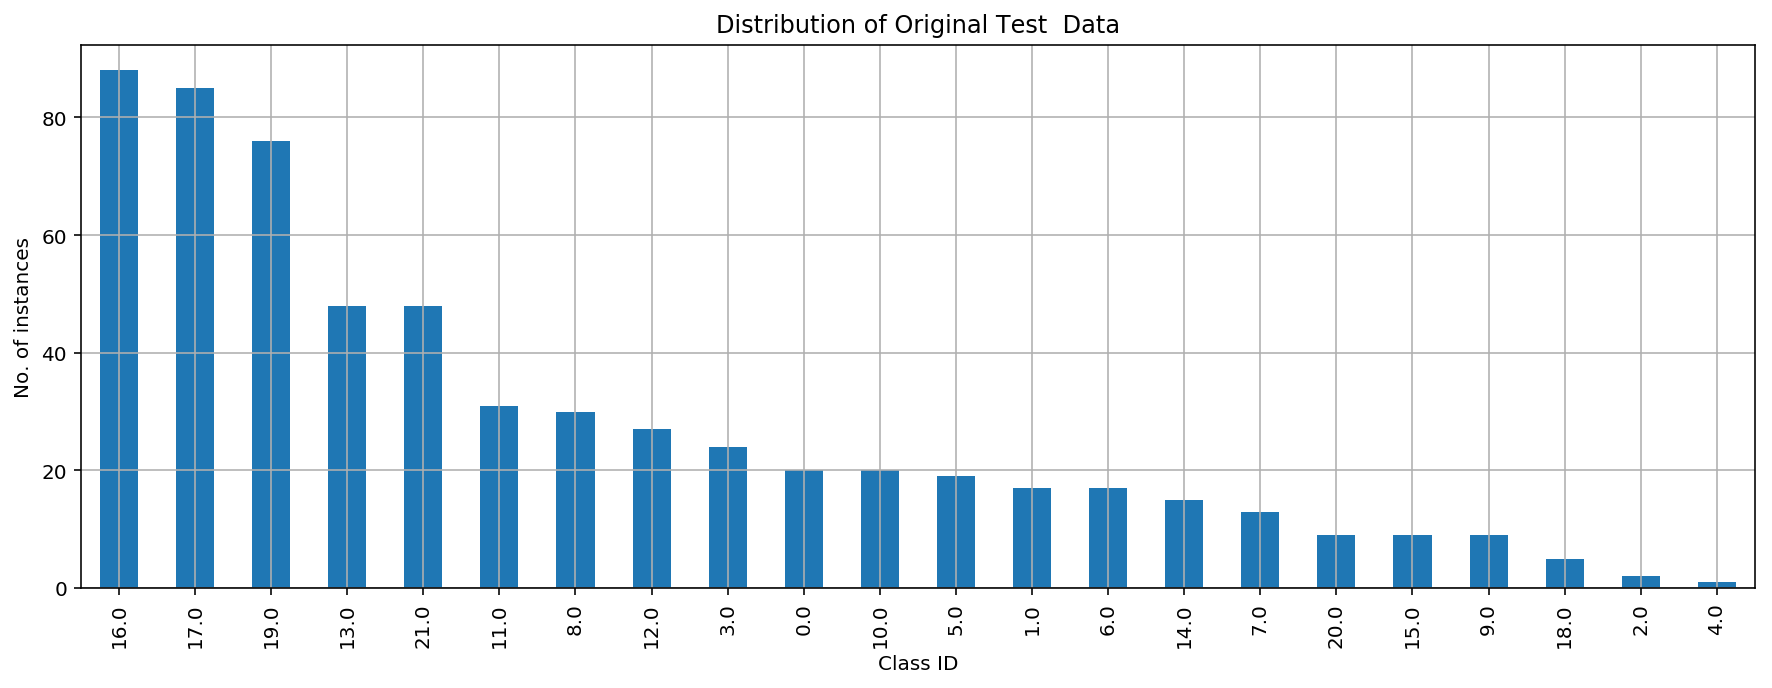

Original Test  Data shape Counter({16.0: 88, 17.0: 85, 19.0: 76, 13.0: 48, 21.0: 48, 11.0: 31, 8.0: 30, 12.0: 27, 3.0: 24, 0.0: 20, 10.0: 20, 5.0: 19, 1.0: 17, 6.0: 17, 14.0: 15, 7.0: 13, 9.0: 9, 15.0: 9, 20.0: 9, 18.0: 5, 2.0: 2, 4.0: 1})


In [8]:
vsl.counter(y_train,"Original Train Data")
vsl.counter(y_test,"Original Test  Data")

I took advantage of sampling techniques in order to tackle the extremely imbalanced data observed in the train and test subsets. During the experimental stage, I compared two cases: 1) Oversampling data  and 2) Undersampling data. Oversampling showed a better performance in comparison to undersampling.

Therefore, I decided to implement an oversampling technique as it proved to have the best performance. By implementing undersampling, I intended to reduce the imbalanced ratio in data and, therefore, to make the learning more feasible for the model. One of the costs of it implies loosing potentially useful data. On the other side, by implementing oversampling, I focused on generating synthetic and useful instances of those classes with very few samples. The impact of this is that overfitting can be more likely. Nevertheless, despite the aforementioned implications, oversampling showed a favorable improvement within the performance metrics considered (e.g. accuracy, precision, recall and F-measure) for this case, making this approach the best solution for performing the classification task required.

I considered three different techniques of oversampling: 1) ADASYN 2) SMOTE and 3) Random Oversampling. I tested different possibilities in order to evaluate the effect they bring to the RFC model. SMOTE showed a better performance than ADASYN. Nevertheless, Random Oversampling proved a slightly better performance for this problem compared to the SMOTE technique. In most of the experiments performed the RFC model using the SMOTE technique presented more cases of misclassification in comparisson to the RFC model using the Random Oversampling approach. Then, based on this observations I decided to implement an RFC model using a Random oversampling with a random state equal to 43.

In [9]:
ros = RandomOverSampler(random_state=RANDOM_STATE)

x_train, y_train = ros.fit_sample(x_train, y_train)
x_test, y_test = ros.fit_sample(x_test, y_test)

After implementing the RandomOverSampler technique, the distribution of the oversampled data is illustrated below. The ratio in the training and testing data is 1:1 between the most and the least popular classes. The training data contains 188 instances for each of the 22 classes. Equally, the testing subset contains 88 samples for each of the 22 classes.

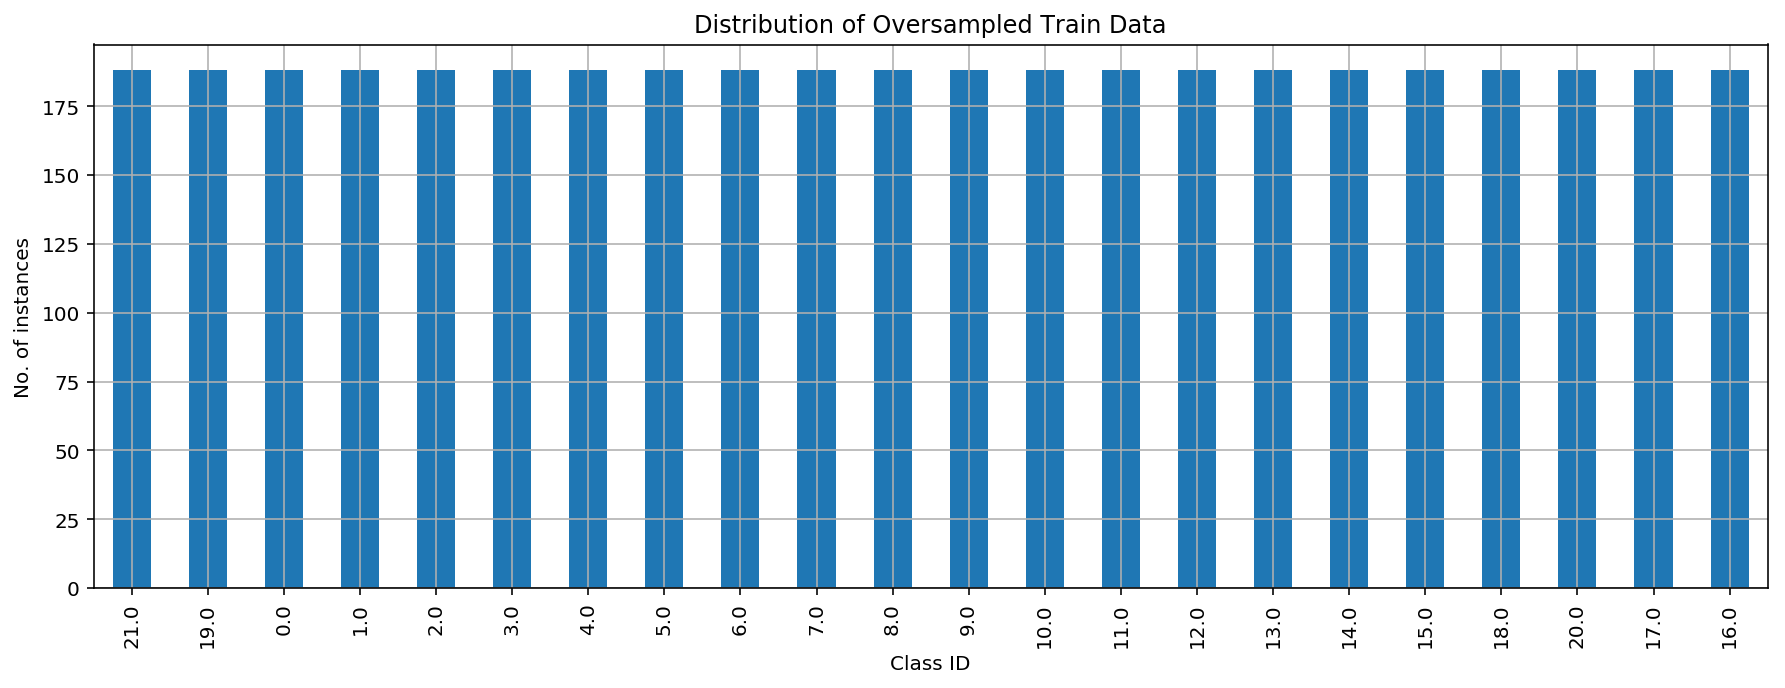

Oversampled Train Data shape Counter({0.0: 188, 1.0: 188, 2.0: 188, 3.0: 188, 4.0: 188, 5.0: 188, 6.0: 188, 7.0: 188, 8.0: 188, 9.0: 188, 10.0: 188, 11.0: 188, 12.0: 188, 13.0: 188, 14.0: 188, 15.0: 188, 16.0: 188, 17.0: 188, 18.0: 188, 19.0: 188, 20.0: 188, 21.0: 188})


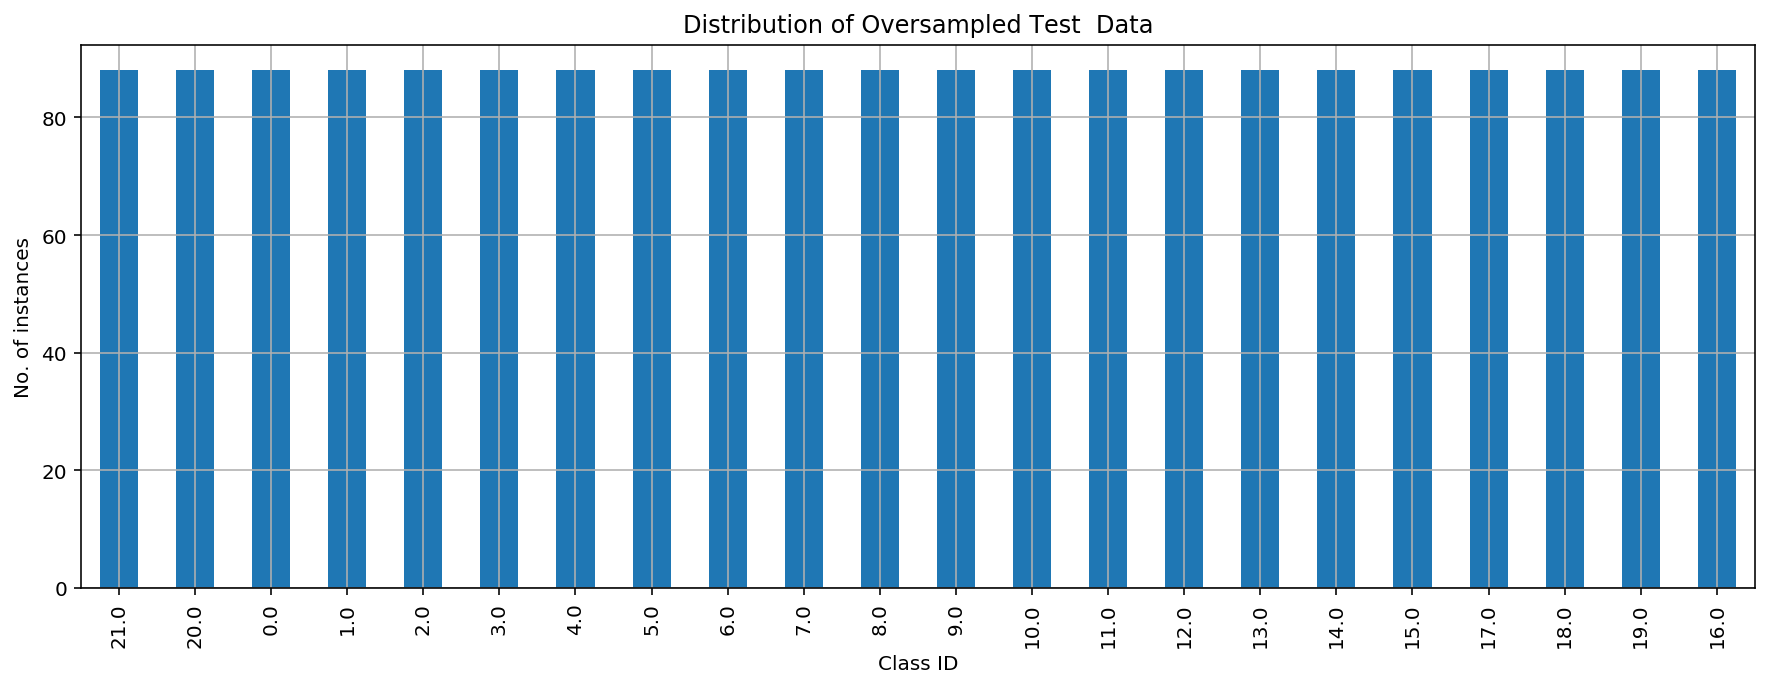

Oversampled Test  Data shape Counter({0.0: 88, 1.0: 88, 2.0: 88, 3.0: 88, 4.0: 88, 5.0: 88, 6.0: 88, 7.0: 88, 8.0: 88, 9.0: 88, 10.0: 88, 11.0: 88, 12.0: 88, 13.0: 88, 14.0: 88, 15.0: 88, 16.0: 88, 17.0: 88, 18.0: 88, 19.0: 88, 20.0: 88, 21.0: 88})


In [10]:
vsl.counter(y_train,"Oversampled Train Data")
vsl.counter(y_test,"Oversampled Test  Data")

The model that showed the better perfomance consists of a Random Forest Classifier of 59 trees. 

The performance of this model proves an accuracy of 80.5%, an average precision of 83%, 81% of average recall and 80% of average F-measure.

In [11]:
clf = RandomForestClassifier(n_estimators= 59, n_jobs=-1)
clf.fit(x_train, y_train)
test_preds = clf.predict(x_test)

In [14]:
print("Accuracy of the model ", clf.score(x_test,y_test))

Accuracy of the model  0.805268595041


In [15]:
print(classification_report_imbalanced(y_test, test_preds))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.90      0.89      1.00      0.89      0.94      0.88        88
        1.0       0.72      0.62      0.99      0.67      0.84      0.69        88
        2.0       0.96      1.00      1.00      0.98      0.98      0.95        88
        3.0       0.64      0.77      0.98      0.70      0.80      0.61        88
        4.0       1.00      1.00      1.00      1.00      1.00      1.00        88
        5.0       0.90      0.95      1.00      0.93      0.95      0.89        88
        6.0       0.90      0.72      1.00      0.80      0.94      0.88        88
        7.0       0.77      0.38      0.99      0.50      0.86      0.73        88
        8.0       0.80      0.76      0.99      0.78      0.89      0.77        88
        9.0       0.94      0.73      1.00      0.82      0.96      0.92        88
       10.0       0.70      0.90      0.98      0.79      0.83      0.68        88
   

The Predictions of the reshaped data are shown in the confusion matrix of below. As observed, most of the walking-fragments used for testing were correctly classified. The main problem in the dataset, the extremely imbalanced data, has been considerably reduced, as few fragments are misclassified with classes 16, 17, 19 or 13 (the most popular classes in the original dataset), and the minority classes in the original data such as classes 2, 4 and 18, now can be identified as similarly as any other class by the model. 

On the other side, class 15 together with class 7 are the ones worst classified by the model. Class 15 is mostly misclasified as class 17. Similarly, label 7 is many times misclasified as class 3, 10 or 17. Likewise, other classes such as label 1, 3 and 6 are some times confused as if they belonged to class 17.

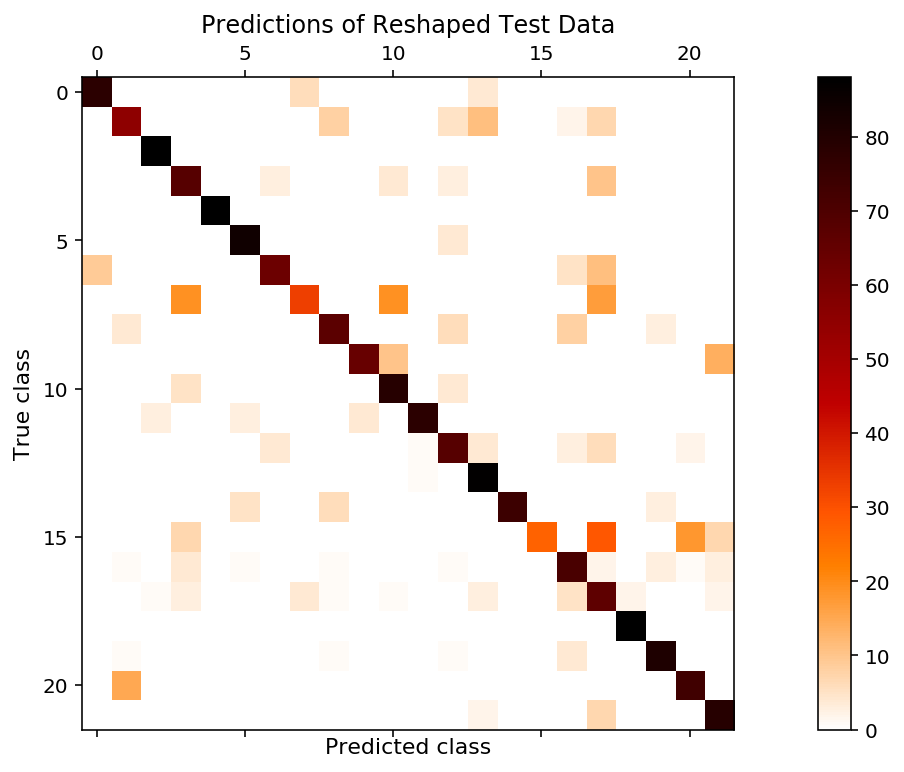

In [16]:
vsl.plot_confusion_matrix(y_test,test_preds,"Predictions of Reshaped Test Data")

Once the model was tested in the altered data, its behavior in a test subset of the original data shows that the model improves much better than if any sampling technique had not been performed. The model proves an accuracy of 82.2%, an average precision of 83%, average recall of 82% and an average F-score of 82%.

In [18]:
test_preds = clf.predict(x_test)
print(classification_report_imbalanced(y_test, test_preds))
print("Accuracy of the model ", clf.score(x_test,y_test))

                   pre       rec       spe        f1       geo       iba       sup

        0.0       0.95      0.90      1.00      0.92      0.97      0.94        20
        1.0       0.69      0.65      0.99      0.67      0.82      0.66        17
        2.0       0.50      1.00      1.00      0.67      0.71      0.48         2
        3.0       0.61      0.79      0.98      0.69      0.78      0.58        24
        4.0       1.00      1.00      1.00      1.00      1.00      1.00         1
        5.0       0.86      0.95      0.99      0.90      0.93      0.84        19
        6.0       0.87      0.76      1.00      0.81      0.93      0.85        17
        7.0       0.55      0.46      0.99      0.50      0.73      0.52        13
        8.0       0.83      0.80      0.99      0.81      0.91      0.81        30
        9.0       0.88      0.78      1.00      0.82      0.93      0.86         9
       10.0       0.78      0.90      0.99      0.84      0.88      0.76        20
   

Similarly to the predictions of the reshaped data, the confusion matrix of below shows a competitive performance when clasifying the different individuals from the original data. Most of the classes are classified correctly. However, classes with labels 1, 6 and 7 are sometimes misclassified. The most popular problem is the confusion that the model has when classifying the most popular classes, which are labels 16 and 17.

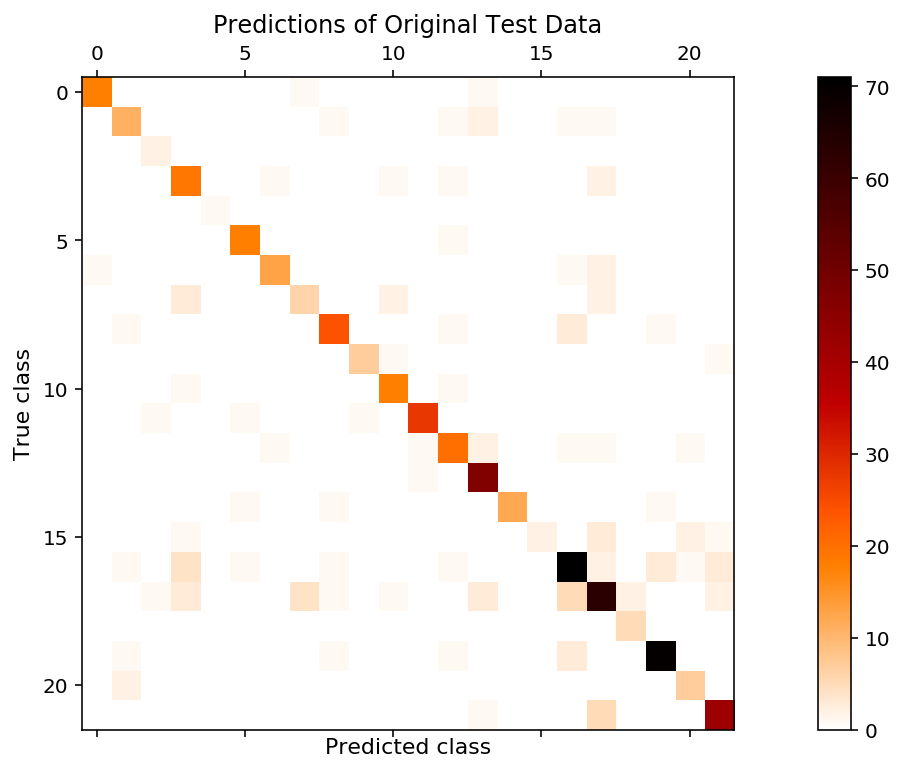

In [19]:
vsl.plot_confusion_matrix(y_test,test_preds,"Predictions of Original Test Data")

Despite the model presented proves a competitive performance, it is clear that diverse improvements can be implemented as next steps to enhance its robustness and classification performance. One of these improvements includes implementing a combined sampling of undersampling and oversampling to diminish the effects of imbalanced data. I have implemented oversampling as it has proven in different applications a better performance when working with small datasets. However, combining undersampling and oversampling can reduce the impact entailed in using each of these techniques separately and can help finding a synthetic but more optimal distribution of the imbalanced data.

Additionally, the manner I have defined the optimal number of trees of the Random Forest Classifier has focused on a greed search, wherein I have set and tested manually different configurations of the RFC model. One of the limitations of this approach is that the space search of the optimal configuration was limited to a certain number of configurations. Then, this can be improved by extending the range of values in the space search, and implementing cross validation techniques, which help to find the optimal configuration of the RFC model automatically, as well as a better split of the data. 

Finally, it is possible that by implementing feature enginering techniques like aggregating additional features that describe more in depth the complexity and behavior of time series data (e.g. Frequency domain related features such as peaks in the Discrete Fourier Transform), the model performance can be enhanced. Nevertheless, it is necessary to consider that it could impact in the complexity of the model and the configuration already defined in this solution. If it would be necessary to improve considerably the classification performance of this data, the possibility of using more complex classification algorithms such as Neural Networks can also be helpful, but the complexity of the model and the necessity of more hardware resources need to be carefully considered; not to mention that it might be the case that more data could be required.



To conclude, the required predictions are saved into the file "y_pred.json". A plot of the distribution of the classes predicted is shown below.

In [20]:
required_data = mp.build_features(dt,sect='test')
y_pred = clf.predict(required_data)
json.dump(list(y_pred), open("y_pred.json", "w+"))

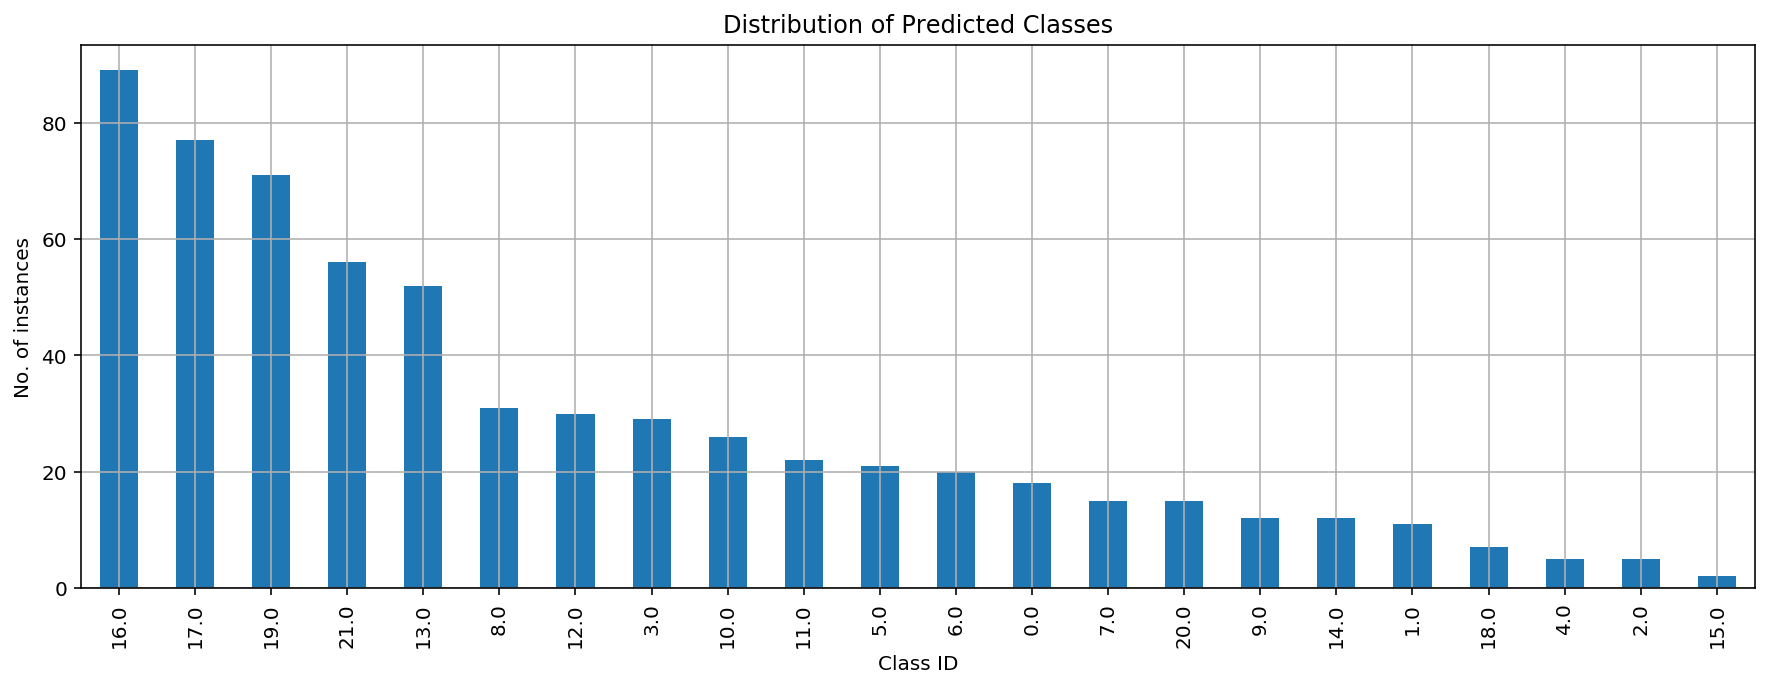

Predicted Classes shape Counter({16.0: 89, 17.0: 77, 19.0: 71, 21.0: 56, 13.0: 52, 8.0: 31, 12.0: 30, 3.0: 29, 10.0: 26, 11.0: 22, 5.0: 21, 6.0: 20, 0.0: 18, 7.0: 15, 20.0: 15, 9.0: 12, 14.0: 12, 1.0: 11, 18.0: 7, 2.0: 5, 4.0: 5, 15.0: 2})


In [21]:
vsl.counter(y_pred,"Predicted Classes")